# Perceptron Multicapa Univariado en el Tiempo
## Caso de Estudio: Serie de entradas múltiples 
### MLP MULTIVARIATE TIME SERIES FORECASTING - One Input Series

Las series de tiempo univariadas son un conjunto de datos compuesto por una sola serie de observaciones con un orden temporal y se requiere un modelo para aprender de la serie de observaciones pasadas para predecir el siguiente valor en la secuencia.
Es decir para este caso, queremos conocer que tanto aprende una red neuronal solo con una fila para entrenar y la misma para test.

## Librerias Necesarias

In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

## Funciones definidas para simplificar el codigo, ya que muchas cosas se pueden reutilizar

In [2]:
""" 
Input:
    figx = Pixeles x
    figy= Pixeles y
    historyXYZ = history del modelo a graficar
    strEvaluacion= tipo de grafica, para definir titulo, subitutlos, etc
    mostrar= booleano para graficar o no
    nombreArchivo=archivo con el cual se guardara el grafico
Output:
    None, muestra la grafica en Matplotlib
Grafica los datos de history de un modelo, ya sea el accucary test vs train o el loss. 
"""
def graficaUnitaria(fix:16,fiy:8,historyXYZ,strEvaluacion,mostrar,nombreArchivo):
    figure(figsize=(fix,fiy))
    pyplot.grid(True)
    if(strEvaluacion=='accuracy'):
        pyplot.title("ACCURACY vs VAL_ACCURACY")
        pyplot.plot(historyXYZ.history['acc'], label='Train ACC')
        pyplot.legend()
        pyplot.plot(historyXYZ.history['val_acc'], label='Test VAL_aCC')
        pyplot.legend()
        #pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
    else:
        pyplot.title("LOSS vs VAL_LOSS")
        pyplot.plot(historyXYZ.history['loss'], label='Train LOSS')
        pyplot.plot(historyXYZ.history['val_loss'], label='Test VAL_LOSS')
        pyplot.legend()
        #pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
            
""" 
Input:
    [10,20,30,40,50...]
Output:
    [[10 15]
     [20 25]
     [30 35]] 65
    [[20 25]
     [30 35]
     [40 45]] 85
    [[30 35]
     [40 45]
     [50 55]] 105
Divide una secuencia univariada dada en varias muestras donde cada muestra 
tiene un número específico de pasos de tiempo y la salida es un solo paso de tiempo
"""
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
"""
Input: 
    listoflist=Lista de Listas  
    valoresPredecir=Lista vacia en la cual se guardara los valores
Output: 
    valoresPredecir=Lista con los valores almacenados
Pasa de un lista de listas a solo una lista
"""
def listoflists2list(listoflist): 
    for i in listoflist: 
        if type(i) == list: 
            listoflists2list(i) 
        else: 
            valoresPredecir.append(i) 

## Lectura de Archivo de Datos CSV y preprocesamiento de los datos

In [6]:
dataset = read_csv('aucorpTrain.csv', header=0, index_col=0)
dataset=dataset.iloc[:,1:2]
values = dataset.values
val=values.tolist()
valoresPredecir = [] 
listoflists2list(val) 

In [4]:
raw_seq = valoresPredecir
print('\t\t\t\t\tValores para Entrenamiento\n\n',raw_seq)


					Valores para Entrenamiento

 [20143, 14219, 15809, 15995, 14974, 14668, 23133, 13098, 15270, 26104, 11180, 16906, 17320, 13554, 21830, 13812, 24465, 14970, 14361, 18686, 13578, 19304, 17567, 14374, 15336, 26150, 22997, 18806, 24257, 22113, 21873, 18867, 21933, 20344, 13829, 10966, 6489, 8595, 8827, 5478, 1661, 2311, 17976, 3629, 6332, 4159, 3250, 6789, 9737, 6695, 6120, 17505, 5709, 14772, 14827, 10968, 18262, 8380, 8697, 7836, 9534, 8074, 14619, 17689, 19054, 8954, 10892, 12894, 19543, 11815, 11775, 9962, 20333, 15008, 17804, 14726, 16427, 17846, 16499, 17460, 17921, 18221, 15846, 19720]


## Entrenamiento de Modelo
### Funcion de Activacion RELU, Medida de Perdida/Error MSE, metrica Accuracy, Numero de Neuronas 100 - 1

In [37]:
n_steps = 3
X, y = split_sequence(raw_seq, n_steps)
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
historyC1 = model.fit(X, y, epochs=2000, verbose=0,validation_split=0.33,nb_epoch=200, batch_size=5)
model.summary()
model.save("modeloUnivariado1001.h5")
print("Modelo Guardado Exitosamente")

C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Modelo Guardado Exitosamente


In [38]:
print('\n\n\t\t\t\t\t Valores resultado del Modelo, Accuracy-Loss del Train y Test \n\n',historyC1.history)



					 Valores resultado del Modelo, Accuracy-Loss del Train y Test 

 {'val_loss': [65457753.481481485, 23477257.62962963, 19154893.70601852, 20745077.365740743, 19356076.21064815, 19369405.787037037, 19482799.5, 19280537.8125, 19491304.777777776, 19535170.916666668, 19482725.798611112, 19534723.574074075, 19841636.953703705, 19631475.888888888, 19766140.708333332, 19873680.98148148, 19701887.564814813, 19630297.81712963, 19683536.14351852, 19986356.51851852, 19686408.587962963, 19754924.291666668, 19765029.233796295, 19864774.069444444, 19835148.888888888, 19777807.02314815, 19700656.435185187, 19857411.361111112, 19754384.185185187, 20020389.0, 19923538.113425925, 19779595.069444444, 19894904.87962963, 19790849.35185185, 19782054.89351852, 20377861.685185187, 19872490.361111112, 19961595.962962963, 19842923.722222224, 19765458.925925925, 19680178.902777776, 19854454.412037037, 19834917.194444444, 19788937.22685185, 19788133.009259257, 19695699.712962963, 19789360.37962963, 19816604

In [39]:
#Prediccion
x_input = array([17460, 17921, 18221])
x_input = x_input.reshape((1, n_steps))
yprediccion = model.predict(x_input, verbose=0)
print('\n\n\t\t\t\t\tValores Input para Prediccion\n\n',x_input)
print('\n\n\t\t\t\t\tValores Output - Prediccion\n\n',yprediccion)



					Valores Input para Prediccion

 [[17460 17921 18221]]


					Valores Output - Prediccion

 [[17372.49]]


Populating the interactive namespace from numpy and matplotlib


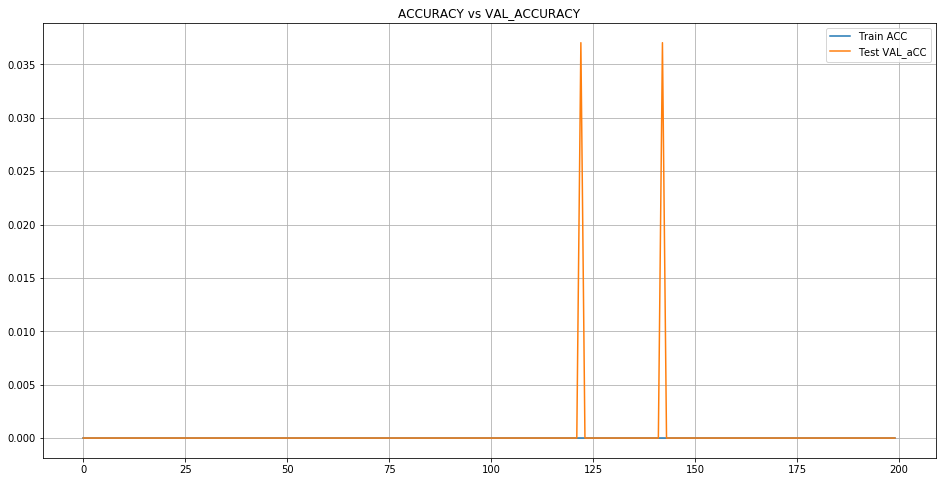

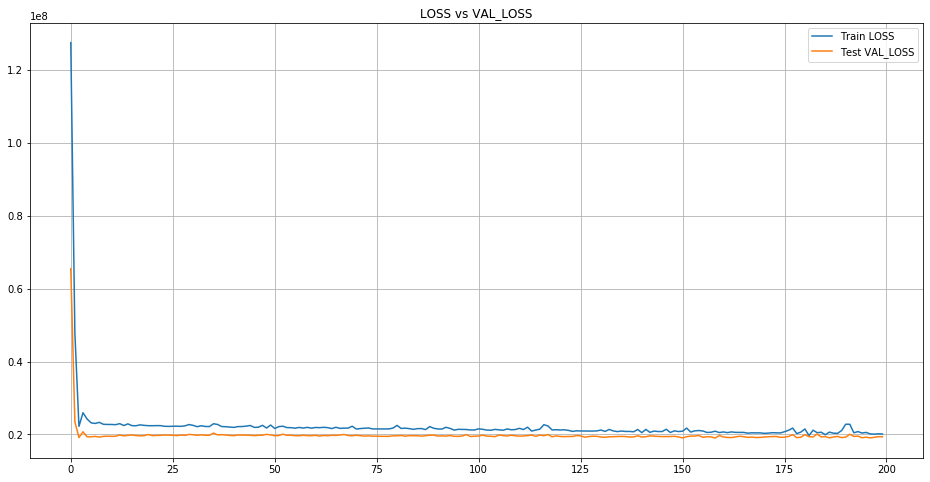

In [40]:
%pylab inline
graficaUnitaria(16,8,historyC1,'accuracy',True,'c1Acc.png')
graficaUnitaria(16,8,historyC1,'loss',True,'c1Loss.png')

# Codigo Completo
# Caso de Estudio 100 Neuronas 200 Epocas

					Valores para Entrenamiento

 [20143, 14219, 15809, 15995, 14974, 14668, 23133, 13098, 15270, 26104, 11180, 16906, 17320, 13554, 21830, 13812, 24465, 14970, 14361, 18686, 13578, 19304, 17567, 14374, 15336, 26150, 22997, 18806, 24257, 22113, 21873, 18867, 21933, 20344, 13829, 10966, 6489, 8595, 8827, 5478, 1661, 2311, 17976, 3629, 6332, 4159, 3250, 6789, 9737, 6695, 6120, 17505, 5709, 14772, 14827, 10968, 18262, 8380, 8697, 7836, 9534, 8074, 14619, 17689, 19054, 8954, 10892, 12894, 19543, 11815, 11775, 9962, 20333, 15008, 17804, 14726, 16427, 17846, 16499, 17460, 17921, 18221, 15846, 19720]


C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\ipykernel_launcher.py:99: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.




					Resultado de Modelo Entrenado


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Modelo Guardado Exitosamente


					Valores Input para Prediccion

 [[17460 17921 18221]]


					Valores Output - Prediccion

 [[17693.777]]
Populating the interactive namespace from numpy and matplotlib


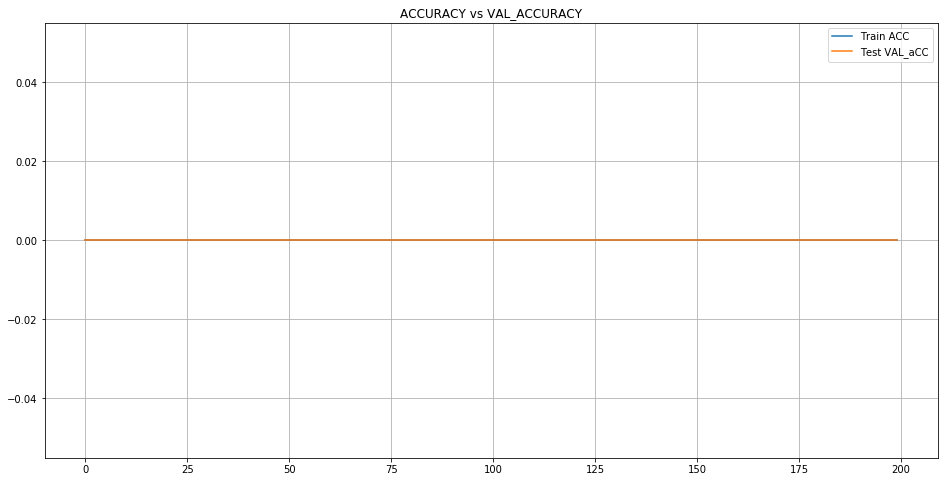

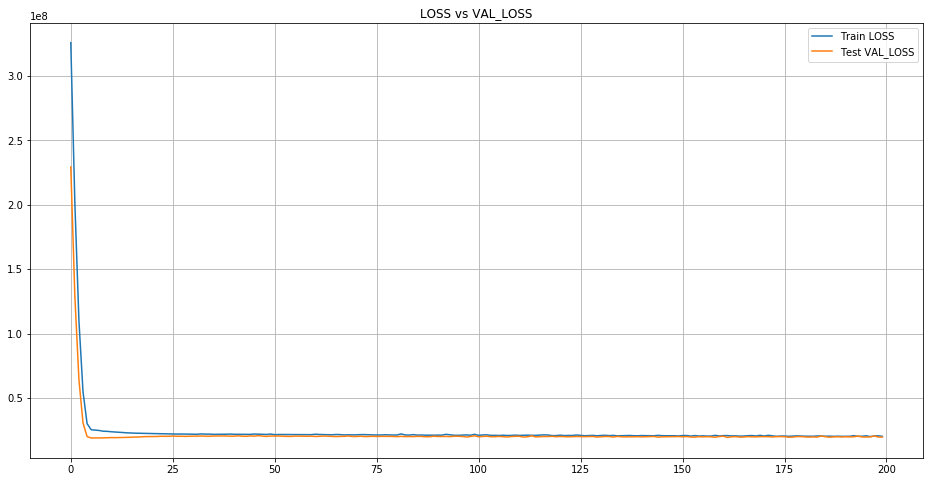

In [8]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
""" 
Input:
    figx = Pixeles x
    figy= Pixeles y
    historyXYZ = history del modelo a graficar
    strEvaluacion= tipo de grafica, para definir titulo, subitutlos, etc
    mostrar= booleano para graficar o no
    nombreArchivo=archivo con el cual se guardara el grafico
Output:
    None, muestra la grafica en Matplotlib
Grafica los datos de history de un modelo, ya sea el accucary test vs train o el loss. 
"""
def graficaUnitaria(fix:16,fiy:8,historyXYZ,strEvaluacion,mostrar,nombreArchivo):
    figure(figsize=(fix,fiy))
    pyplot.grid(True)
    if(strEvaluacion=='accuracy'):
        pyplot.title("ACCURACY vs VAL_ACCURACY")
        pyplot.plot(historyXYZ.history['acc'], label='Train ACC')
        pyplot.legend()
        pyplot.plot(historyXYZ.history['val_acc'], label='Test VAL_aCC')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
    else:
        pyplot.title("LOSS vs VAL_LOSS")
        pyplot.plot(historyXYZ.history['loss'], label='Train LOSS')
        pyplot.plot(historyXYZ.history['val_loss'], label='Test VAL_LOSS')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
            
""" 
Input:
    [10,20,30,40,50...]
Output:
    [[10 15]
     [20 25]
     [30 35]] 65
    [[20 25]
     [30 35]
     [40 45]] 85
    [[30 35]
     [40 45]
     [50 55]] 105
Divide una secuencia univariada dada en varias muestras donde cada muestra 
tiene un número específico de pasos de tiempo y la salida es un solo paso de tiempo
"""
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
"""
Input: 
    listoflist=Lista de Listas  
    valoresPredecir=Lista vacia en la cual se guardara los valores
Output: 
    valoresPredecir=Lista con los valores almacenados
Pasa de un lista de listas a solo una lista
"""
def listoflists2list(listoflist): 
    for i in listoflist: 
        if type(i) == list: 
            listoflists2list(i) 
        else: 
            valoresPredecir.append(i) 
            
dataset = read_csv('aucorpTrain.csv', header=0, index_col=0)
dataset=dataset.iloc[:,1:2]
values = dataset.values
val=values.tolist()
valoresPredecir = [] 
listoflists2list(val) 
raw_seq = valoresPredecir
print('\t\t\t\t\tValores para Entrenamiento\n\n',raw_seq)
n_steps = 3
X, y = split_sequence(raw_seq, n_steps)
# Modelo
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
historyC1 = model.fit(X, y, epochs=2000, verbose=0,validation_split=0.33,nb_epoch=200, batch_size=5)
print('\n\n\t\t\t\t\tResultado de Modelo Entrenado\n\n')
model.summary()
model.save("modeloUnivariado200100.h5")
print("Modelo Guardado Exitosamente")
#Prediccion
x_input = array([17460, 17921, 18221])
x_input = x_input.reshape((1, n_steps))
yprediccion = model.predict(x_input, verbose=0)
print('\n\n\t\t\t\t\tValores Input para Prediccion\n\n',x_input)
print('\n\n\t\t\t\t\tValores Output - Prediccion\n\n',yprediccion)
%pylab inline
graficaUnitaria(16,8,historyC1,'accuracy',True,'modeloUnivariado200100accuracyMLPUnivariado.png')
graficaUnitaria(16,8,historyC1,'loss',True,'modeloUnivariado200100lossMLPUnivariado.png')


# Caso de Estudio 12 Neuronas 100 Epocas

					Valores para Entrenamiento

 [20143, 14219, 15809, 15995, 14974, 14668, 23133, 13098, 15270, 26104, 11180, 16906, 17320, 13554, 21830, 13812, 24465, 14970, 14361, 18686, 13578, 19304, 17567, 14374, 15336, 26150, 22997, 18806, 24257, 22113, 21873, 18867, 21933, 20344, 13829, 10966, 6489, 8595, 8827, 5478, 1661, 2311, 17976, 3629, 6332, 4159, 3250, 6789, 9737, 6695, 6120, 17505, 5709, 14772, 14827, 10968, 18262, 8380, 8697, 7836, 9534, 8074, 14619, 17689, 19054, 8954, 10892, 12894, 19543, 11815, 11775, 9962, 20333, 15008, 17804, 14726, 16427, 17846, 16499, 17460, 17921, 18221, 15846, 19720]


C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\ipykernel_launcher.py:99: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.




					Resultado de Modelo Entrenado


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 13        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Modelo Guardado Exitosamente


					Valores Input para Prediccion

 [[17460 17921 18221]]


					Valores Output - Prediccion

 [[17731.096]]
Populating the interactive namespace from numpy and matplotlib


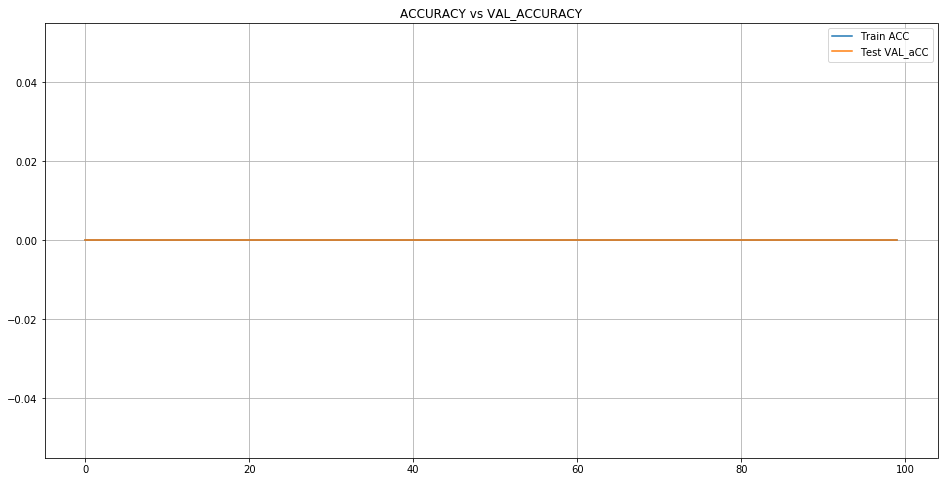

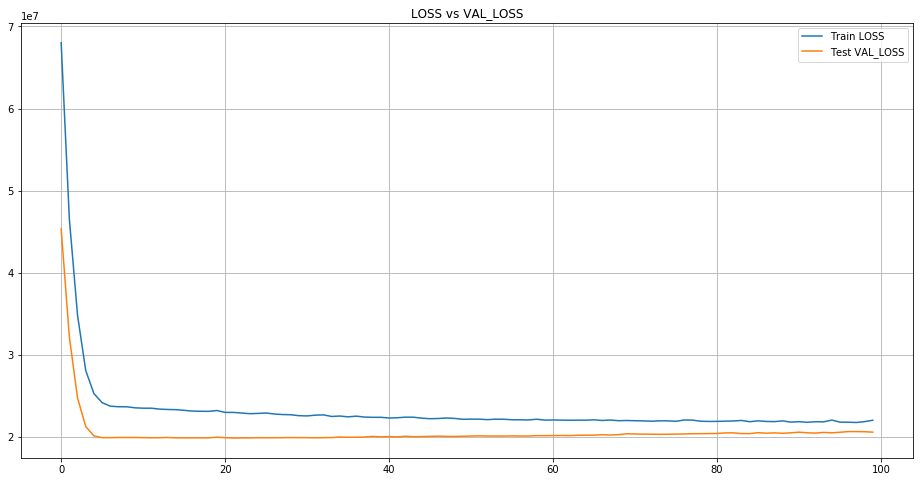

In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
""" 
Input:
    figx = Pixeles x
    figy= Pixeles y
    historyXYZ = history del modelo a graficar
    strEvaluacion= tipo de grafica, para definir titulo, subitutlos, etc
    mostrar= booleano para graficar o no
    nombreArchivo=archivo con el cual se guardara el grafico
Output:
    None, muestra la grafica en Matplotlib
Grafica los datos de history de un modelo, ya sea el accucary test vs train o el loss. 
"""
def graficaUnitaria(fix:16,fiy:8,historyXYZ,strEvaluacion,mostrar,nombreArchivo):
    figure(figsize=(fix,fiy))
    pyplot.grid(True)
    if(strEvaluacion=='accuracy'):
        pyplot.title("ACCURACY vs VAL_ACCURACY")
        pyplot.plot(historyXYZ.history['acc'], label='Train ACC')
        pyplot.legend()
        pyplot.plot(historyXYZ.history['val_acc'], label='Test VAL_aCC')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
    else:
        pyplot.title("LOSS vs VAL_LOSS")
        pyplot.plot(historyXYZ.history['loss'], label='Train LOSS')
        pyplot.plot(historyXYZ.history['val_loss'], label='Test VAL_LOSS')
        pyplot.legend()
        pyplot.savefig(nombreArchivo, dpi=300)
        if(mostrar):
            pyplot.show()
            
""" 
Input:
    [10,20,30,40,50...]
Output:
    [[10 15]
     [20 25]
     [30 35]] 65
    [[20 25]
     [30 35]
     [40 45]] 85
    [[30 35]
     [40 45]
     [50 55]] 105
Divide una secuencia univariada dada en varias muestras donde cada muestra 
tiene un número específico de pasos de tiempo y la salida es un solo paso de tiempo
"""
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
"""
Input: 
    listoflist=Lista de Listas  
    valoresPredecir=Lista vacia en la cual se guardara los valores
Output: 
    valoresPredecir=Lista con los valores almacenados
Pasa de un lista de listas a solo una lista
"""
def listoflists2list(listoflist): 
    for i in listoflist: 
        if type(i) == list: 
            listoflists2list(i) 
        else: 
            valoresPredecir.append(i) 
            
dataset = read_csv('aucorpTrain.csv', header=0, index_col=0)
dataset=dataset.iloc[:,1:2]
values = dataset.values
val=values.tolist()
valoresPredecir = [] 
listoflists2list(val) 
raw_seq = valoresPredecir
print('\t\t\t\t\tValores para Entrenamiento\n\n',raw_seq)
n_steps = 3
X, y = split_sequence(raw_seq, n_steps)
# Modelo
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
historyC1 = model.fit(X, y, epochs=2000, verbose=0,validation_split=0.33,nb_epoch=100, batch_size=5)
print('\n\n\t\t\t\t\tResultado de Modelo Entrenado\n\n')
model.summary()
model.save("modeloUnivariado20012 .h5")
print("Modelo Guardado Exitosamente")
#Prediccion
x_input = array([17460, 17921, 18221])
x_input = x_input.reshape((1, n_steps))
yprediccion = model.predict(x_input, verbose=0)
print('\n\n\t\t\t\t\tValores Input para Prediccion\n\n',x_input)
print('\n\n\t\t\t\t\tValores Output - Prediccion\n\n',yprediccion)
%pylab inline
graficaUnitaria(16,8,historyC1,'accuracy',True,'modeloUnivariado20012accuracyMLPUnivariado.png')
graficaUnitaria(16,8,historyC1,'loss',True,'modeloUnivariado20012lossMLPUnivariado.png')
